In [ ]:
# Update to the latest neurods
!pip install git+https://github.com/choldgraf/neurods.git --user

# Overview

In the last lab, we computed event-related averages for responses to different categories of objects. We saw that response in fMRI emerge slowly (2-3 TRs or 4-6 seconds) after the onset of a stimulus. Fundamentally, the most common thing that we want to know in fMRI experiments is how some event is related to brain responses. The event related averages show us that some areas of the brain respond more to some stimuli than others, but we would like a more firm statistical basis before we draw any conclusions from our data. This week, we will introduce how to model the delay in that data.

# Goals

We will show you how to account for the delay in the fMRI signal after a stimulus or other event. 

In [4]:
# Imports
import neurods
import numpy as np
import matplotlib.pyplot as plt
# Configure defaults for plots
# (This is overkill, perhaps, but good tips to show.)
import matplotlib
from cycler import cycler
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.aspect'] = 'auto'
matplotlib.rcParams['image.cmap'] = 'viridis'
# New defaults!
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', ['k','r', (0,0,0.8),(0.95,0.8,0),(0,.8,0),(1.0, 0.5, 0)])

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# fMRI responses do not occur immediately after a stimulus

fMRI responses emerge slowly after the onset of a stimulus (or any other event). This means that, if we want to make an accurate mathematical model of how the brain responds, we have to somehow incorporate this delay into our model. 

To do this, we will borrow a concept from signal processing theory called the impulse response function. An impulse response function describes the way a signal emerges (for any system) after an event. The way the BOLD response emerges after an experimental event is called the *hemodynamic response function* or HRF. 

A great deal of early fMRI research went into accurately describing how the BOLD signal rises, falls, and resets to baseline after an event. **[NEED REFERENCES]** We will rely on the conclusions of this research without going into great detail about it. The practical upshot is that BOLD responses have a fairly characteristic shape, which is well described by a mathematical function called a *gamma function*. 

We have provided you with a function to produce this canonical HRF within the neurods module: 

    neurods.fmri.hrf()

hrf_1 shape is (32,)


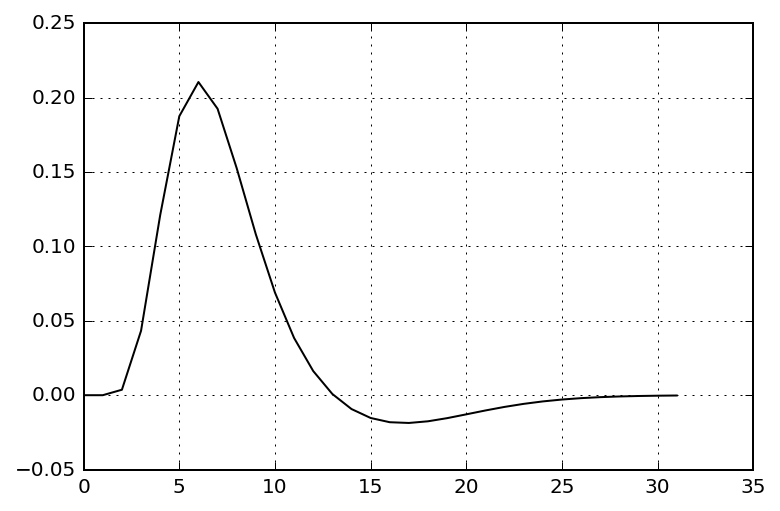

In [6]:
# Set the TR, or repetition time, a.k.a. the sampling rate for our data

TR = 1.0 # One measurement per second

# let's import a function that makes hrfs:
from neurods.fmri import hrf as generate_hfr

# Get a canonical hrf_1
t_hrf, hrf_1 = generate_hfr(tr=TR)
print('hrf_1 shape is', hrf_1.shape)
__ = plt.plot(t_hrf,hrf_1)


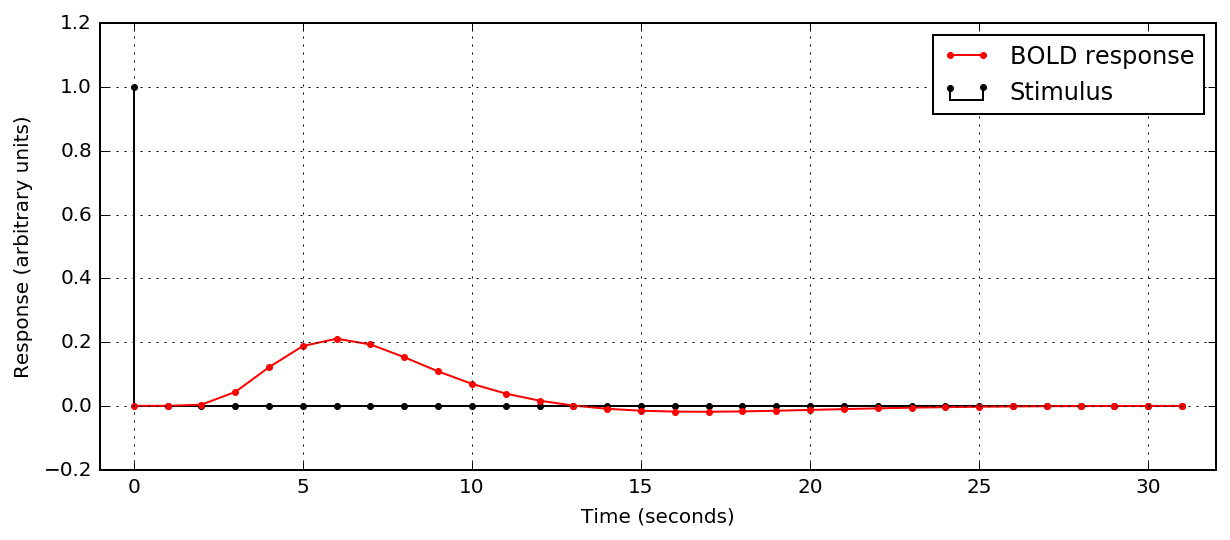

In [7]:
# This is a response to a single discrete stimulus appearing at time 0, like this:
t = t_hrf
stimulus = np.zeros(t.shape)
stimulus[0] = 1

# We will be plotting stimulus / response pairs several times, so let's 
# just make a function for this right away.
def stim_resp_plot(t, stimulus, response, yl=(-0.2, 1.2)):
    """Plot stimulus and response"""
    plt.figure(figsize=(10,4))
    # Note stem() function!
    plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')
    plt.plot(t, response, 'r.-', label='BOLD response')
    plt.ylim(yl)
    plt.xlim([-1,t.max()+1])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Response (arbitrary units)')
    _ = plt.legend()

# Plot
stim_resp_plot(t, stimulus, hrf_1)

Play with the parameters of the hrf() function. See what happens if you change them. 

In [8]:
### STUDENT ANSWER
# hrf_01 = neurods.fmri.hrf(blah=1, blah2=2, ...)
# ETC...

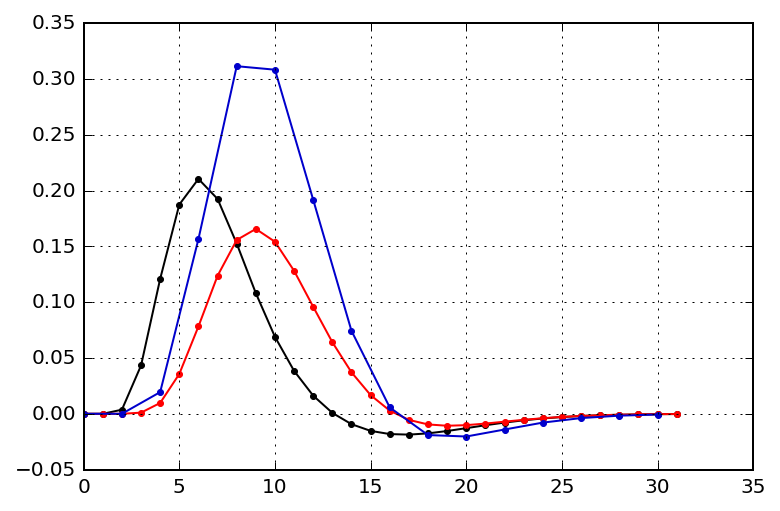

In [9]:
### STUDENT ANSWER
pkw = dict(marker='.')
plt.plot(*neurods.fmri.hrf(), **pkw)
plt.plot(*neurods.fmri.hrf(pttp=8), **pkw)
plt.plot(*neurods.fmri.hrf(pttp=8, tr=2), **pkw)

Every time an event occurs, this slow hemodynamic response emerges. We will slowly explore how this hemodynamic response can affect the signal in a voxel.

First, we start with a hypothetical run of 200 TRs, in which no stimuli is presented.

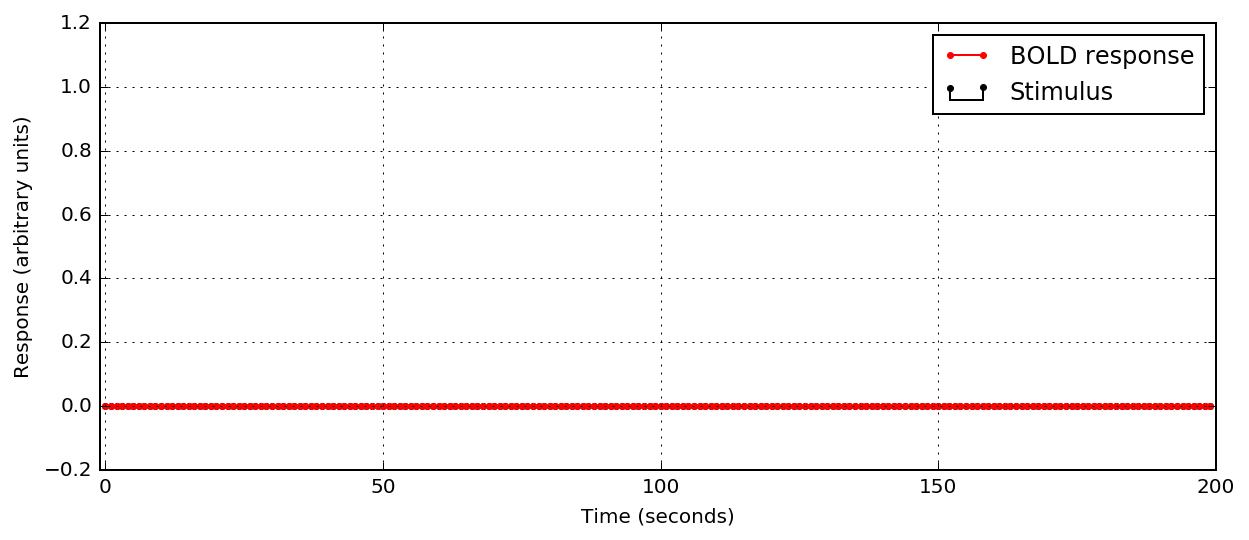

In [10]:
n = 200 # Total time points (TRs)
t = np.arange(n,)
# no stimulus
stimuli = np.zeros((n))
# we assume no response
response = np.zeros((n))
# here we plot the function
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))
# and see nothing as predicted.

We saw above how the time changes when we have a stimulus at time 0. Imagine we have a stimulus at time i=10. What would happen then to the activity? Just assume that this stimulus will create an hrf that will be *added* to the signal from times i to times i + hrf_length (hrf_length is the length of our theoretical hrf, which was 32 above).

Attention: make sure you modify response by adding something to it's values, and not just changing it.

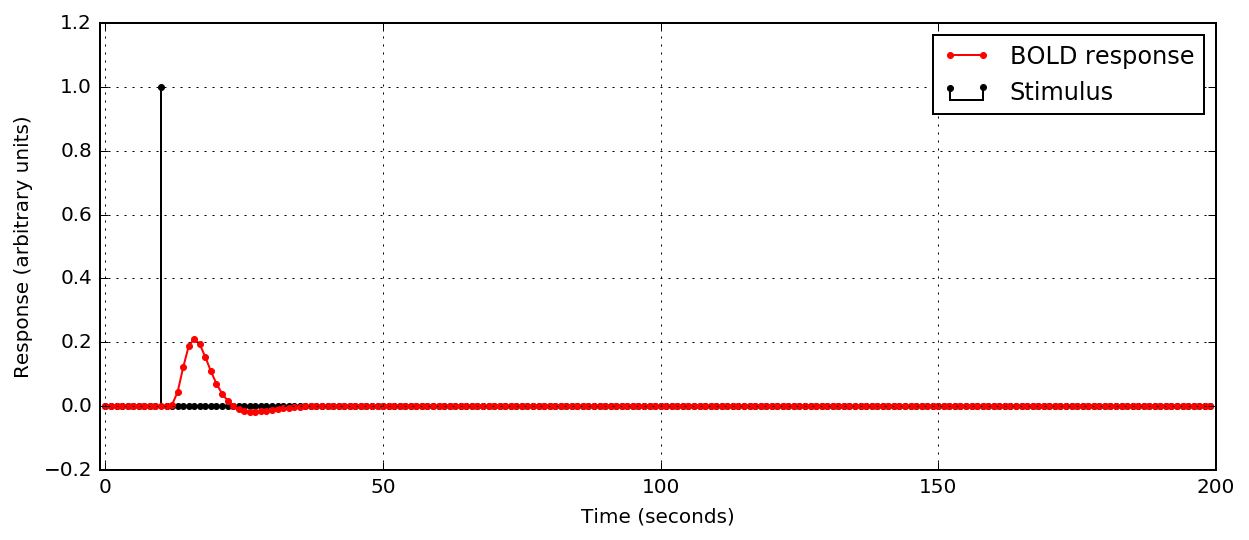

In [11]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

i = 10
stimuli[i] = 1

# now add the response to stimulus i to the response, then plot using stim_resp_plot like above
### STUDENT ANSWER
response[range(i,i+hrf_length)] += hrf_1
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

Now let's say that there were 3 stimuli, one at 10, one at 70 and one at 150, plot the resulting activity. 

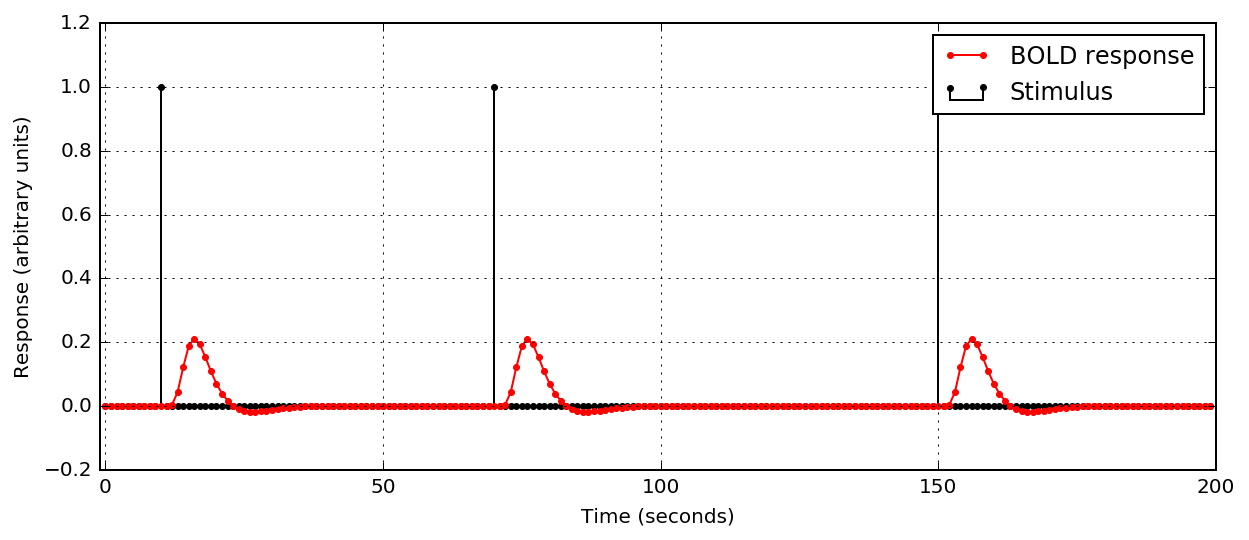

In [12]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [10, 70, 150]
for i in stim_times:
    stimuli[i] = 1

# now add the response to those stimuli i, then plot using stim_resp_plot like above
### STUDENT ANSWER
for i in stim_times:
    response[range(i,i+hrf_length)] += hrf_1
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

Now say that the stimuli are closer together than the length of the hemodynamic function: let's say they occur at times 10, 21, 25, 70, 71,74, 75, 80 and 150, what happens? 

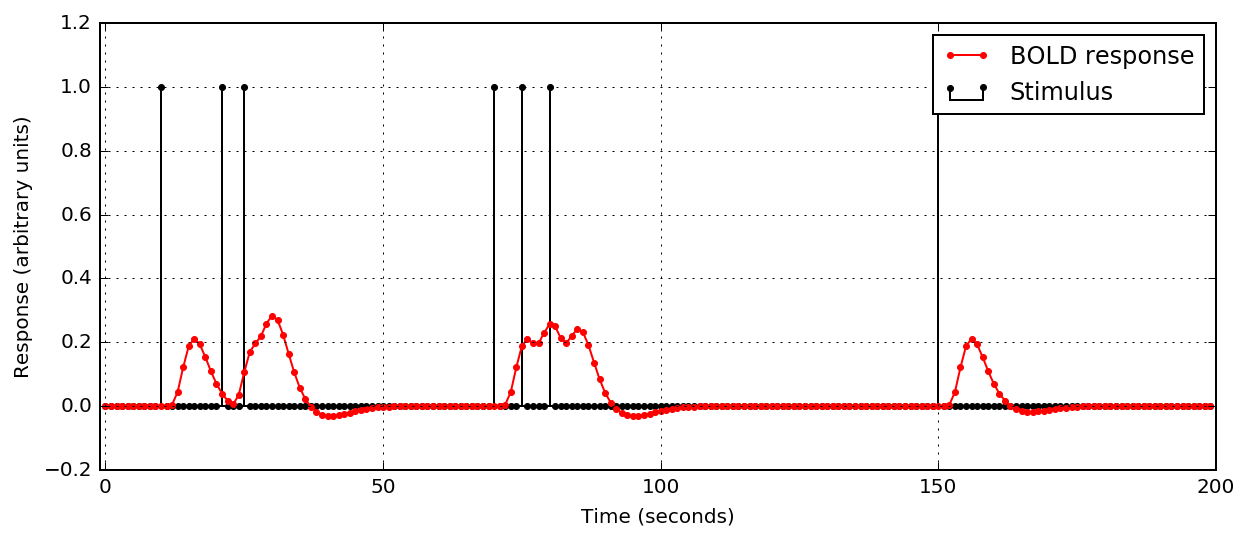

In [13]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [10,21,25, 70, 75, 80, 150]
for i in stim_times:
    stimuli[i] = 1

# now add the response to stimulus i to the response, then plot using stim_resp_plot like above
### STUDENT ANSWER
for i in stim_times:
    response[range(i,i+hrf_length)] += hrf_1
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

What happens to your script if the stimulus appears at time 180? If it breaks, you need to make a change involving the min function.

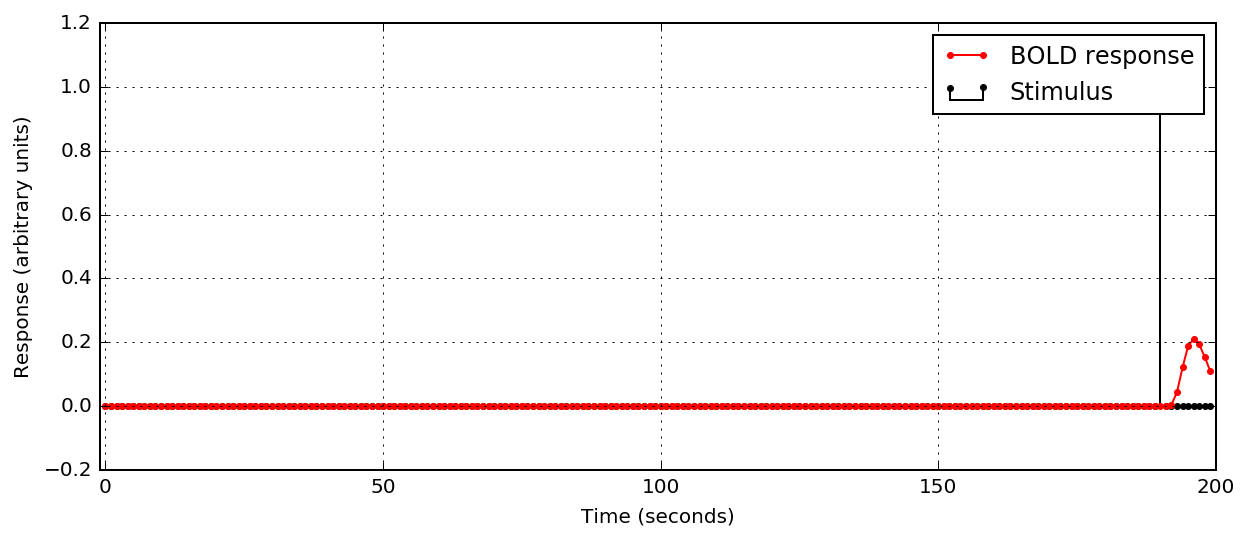

In [14]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [190]
for i in stim_times:
    stimuli[i] = 1

# now add the response to stimulus i to the response, then plot using stim_resp_plot like above
### STUDENT ANSWER
for i in stim_times:
    index = range(i, min(i+hrf_length,n) )
    response[index] += hrf_1[:len(index)]
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

Now write a function that will produce the correct response vectors given the stimulus vector and the hrf_1 vector. Make sure that the function will go over every element in the stimulus vector. You might need to do an adjustment.

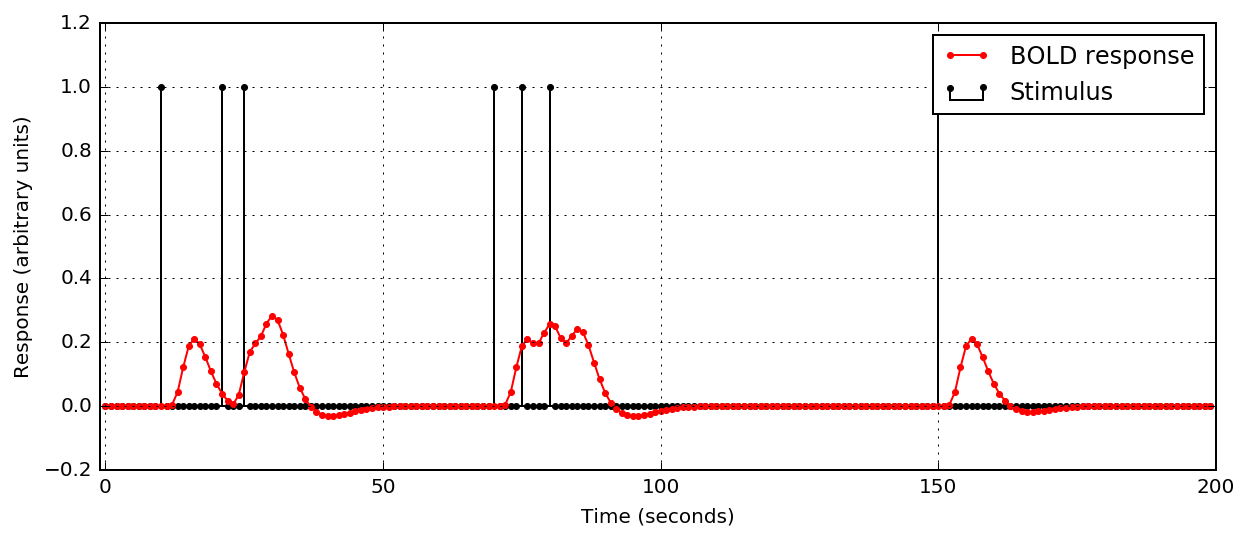

In [15]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = [10,21,25, 70, 75, 80, 150]
for i in stim_times:
    stimuli[i] = 1

# define your function here, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    for i in range(n):
### STUDENT ANSWER
        if stimulus_vec[i]==1: # one way to do it: only if I have a stimulus, I will add a response
            index = range(i, min(i+hrf_length,n) )
            response[index] += hrf_canonical[:len(index)]
    return response

response = gen_responses(stimuli,hrf_1)
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

Now assume that the stimulus occurs with different intensities: for example, a tactile stimulus with different levels of intensities. The assumption is that the response from the occurence of each feature is proportional to the intensity of the feature. If your code doesn't account for this, you should change it:

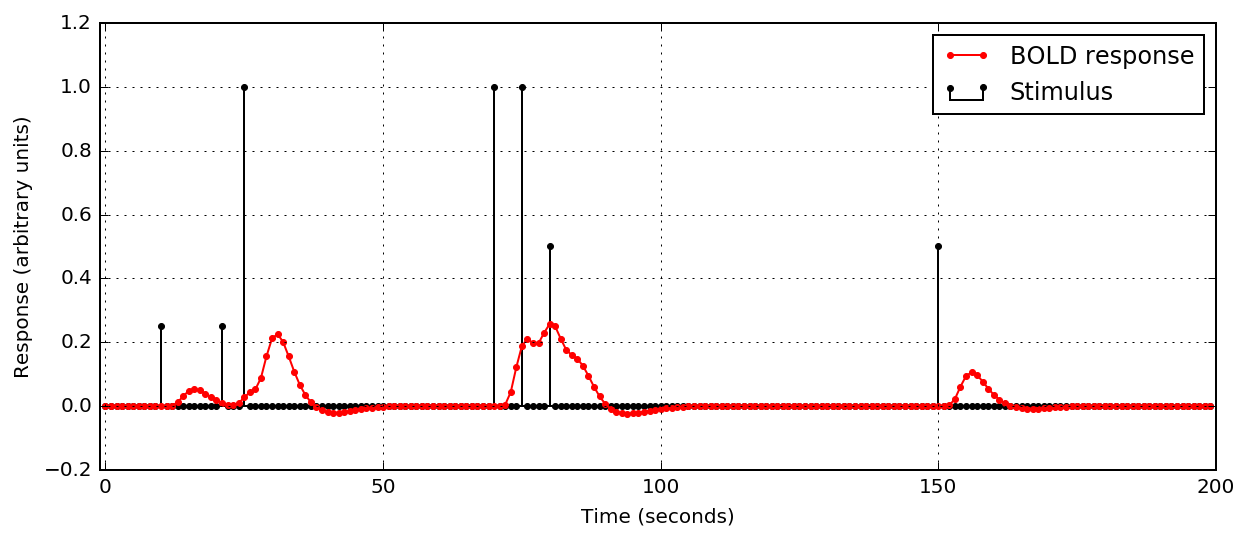

In [16]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = [10,21,25, 70, 75, 80, 150]
stim_intensities = [0.25,0.25,1, 1, 1, 0.5, 0.5]
for idx, i_time in enumerate(stim_times):
    stimuli[i_time] = stim_intensities[idx]

# define your function here, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    for i in range(n):
### STUDENT ANSWER
        index = range(i, min(i+hrf_length,n) )
        response[index] +=  stimuli[i]*hrf_canonical[:len(index)]
    return response

response = gen_responses(stimuli,hrf_1)
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

In [17]:
### TEACHER NOTE
# Make sure to specify that the new hrfs should be added, i.e. the signal shouldn't 
# just be changed directly.

Now let's say we have a _blocked_ stimulus, i.e. the simulus is on for 30 seconds, starting at 10, 70 and 130:

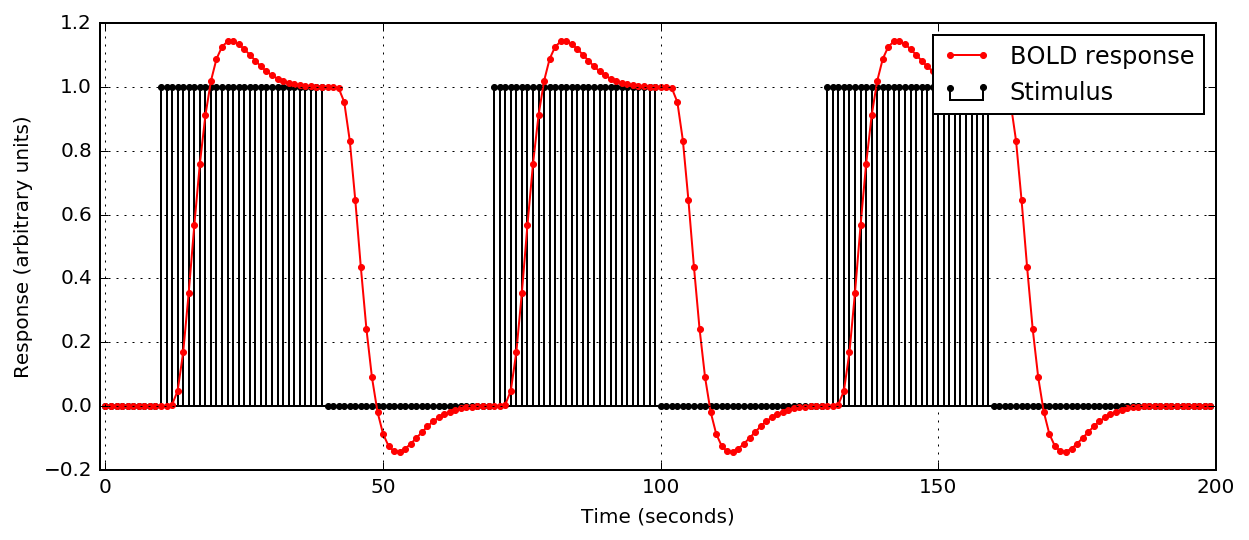

In [18]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = list(range(10,40)) + list(range(70,100))+ list(range(130,160))
for i in stim_times:
    stimuli[i] = 1

# you can use your function here again, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    for i in range(n):
### STUDENT ANSWER
        index = range(i, min(i+hrf_length,n) )
        response[index] +=  stimuli[i]*hrf_canonical[:len(index)]
    return response

response = gen_responses(stimuli,hrf_1)
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

Effectively, a train of 30 spikes at the sampling frequency 1s is the same as having a constant step function for 30 seconds. What we did above is called a convolution: we have a signal, the stimulus. This signal is going to be modified by a function, the hrf in our case. Convolution is an integration operation where you integrate an initial signal with a modifying function, in a way that reflects how previous values of the signal (before time i) affect the new transformed signal (at time i). What we did above is a simplified integration: we are working in discrete time and we manually added the contributions at each time. 

<img src="wikipedia_box_convolution.gif">

This is what we did:
Let's call $T$ the length of the HRF. We went though the stimulus and made it affect the response at later stages. At the end, every value of the response $r(i)$ will have contributions to the stimulus $s$ from the previous $T$ time points:

$r(i) = s(i-1) \times hrf(1) +  s(i-2) \times hrf(2) + ... +  s(i-T+1)  \times hrf(T) \\
  \ \ \   = \Sigma_{\tau=1}^{T} s(i-\tau) \times h(\tau)$

This is exactly the expression of the discrete convolution function between functions $s$ and $h$. In continuous time, the convolution operation is written as:

$r(i) = \int_{\tau=1}^{T} s(i-\tau) \times h(\tau) = s \ast h(i)$

Here we will use a numpy function that is already implemented for this:

resulting response has length 231 and should be cropped


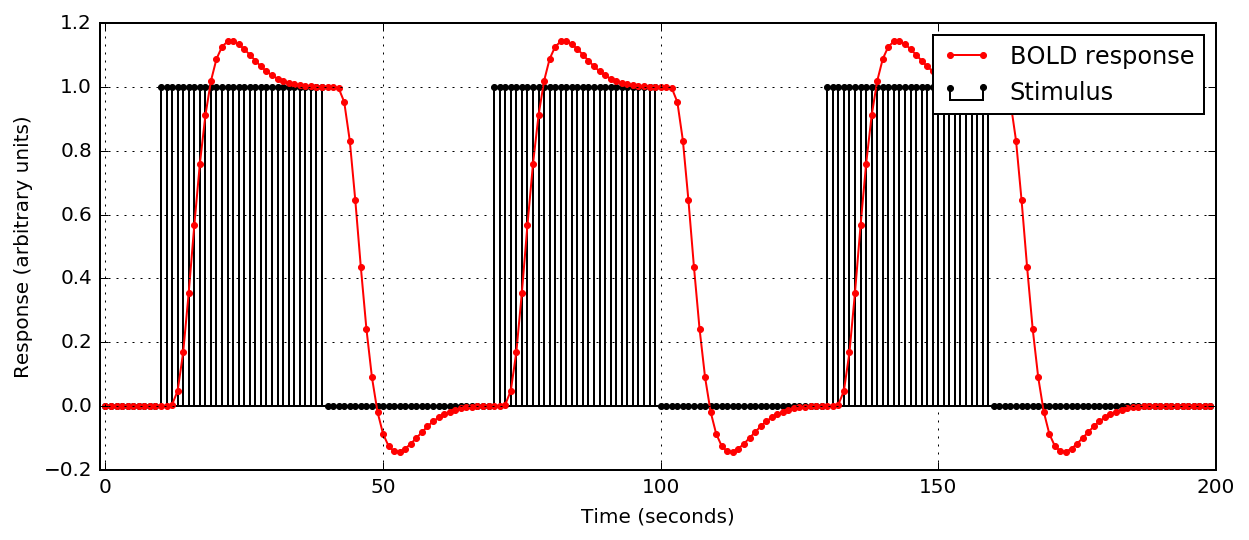

In [19]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
#response = np.zeros((n))

stim_times = list(range(10,40)) + list(range(70,100))+ list(range(130,160))
for i in stim_times:
    stimuli[i] = 1

response = np.convolve(stimuli, hrf_1, mode='full')
print('resulting response has length {} and should be cropped'.format(len(response)))
# Here we also have to crop the signal because np.convolve creates a signal longer than n
# because it computes the response of stimuli appearing up to time n-1, which affect the 
# signal for longer than n.
stim_resp_plot(t, stimuli, response[:n], yl=(-0.2, 1.2))

Let's look at another example: the convolution of a simple periodic signal with the HRF function.

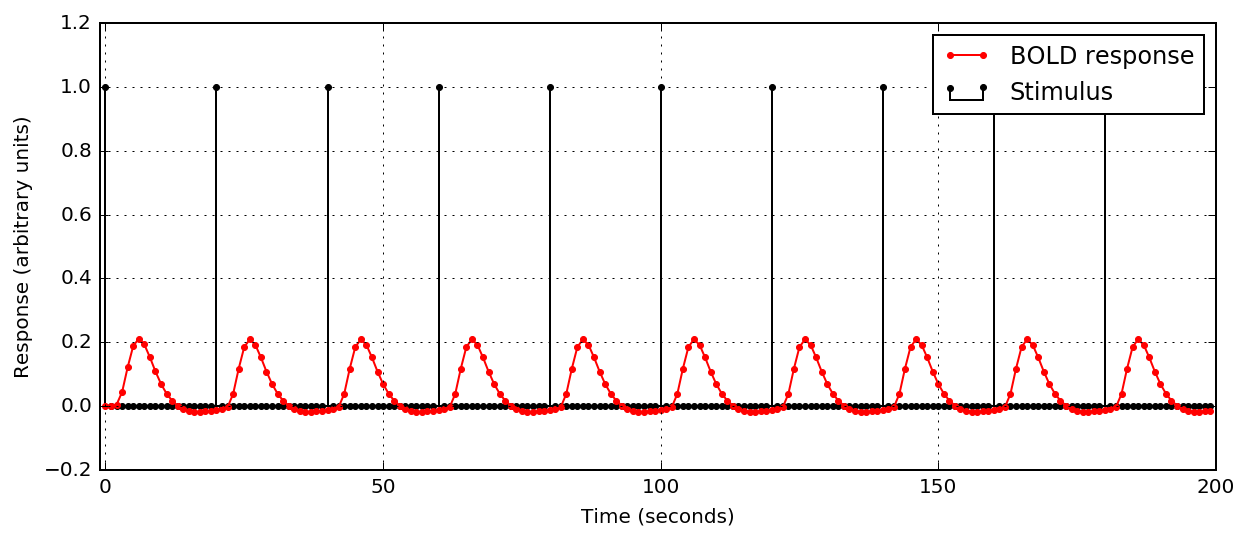

In [20]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
#response = np.zeros((n))

stim_times = range(0,200,20)
for i in stim_times:
    stimuli[i] = 1
    
### STUDENT ANSWER
response = np.convolve(stimuli, hrf_1, mode='full')
# Here we also have to crop the signal!
stim_resp_plot(t, stimuli, response[:n], yl=(-0.2, 1.2))

And now of overlapping events:

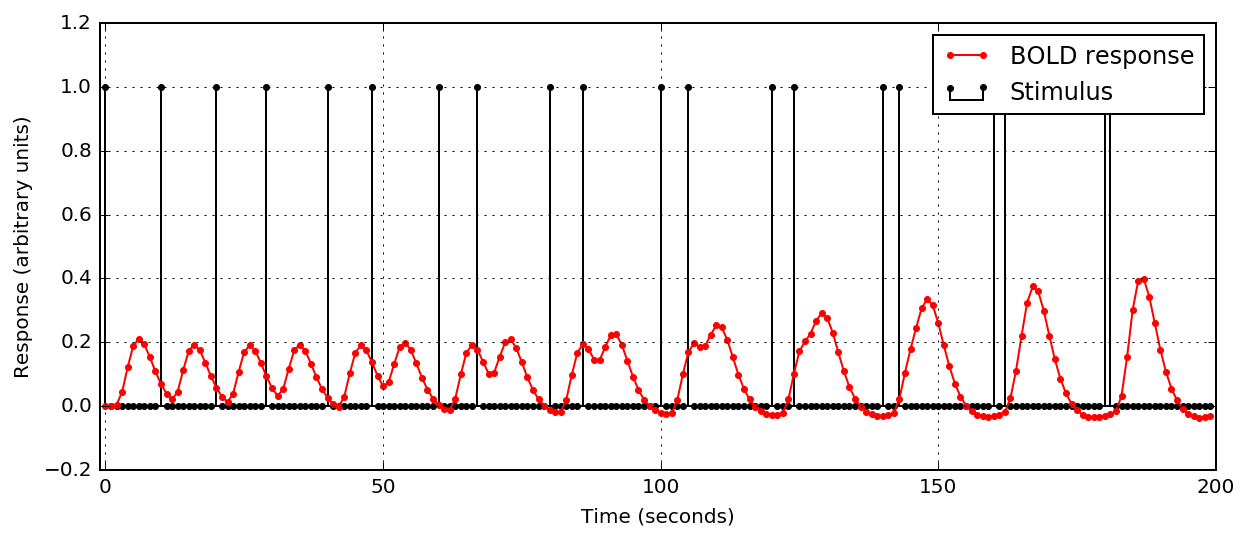

In [21]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
#response = np.zeros((n))

idx = np.arange(0, n, 20)
stimuli[idx] = 1
add = np.arange(len(idx), 0, -1)
stimuli[idx+add] = 1 
    
### STUDENT ANSWER
response = np.convolve(stimuli, hrf_1, mode='full')
# Here we also have to crop the signal!
stim_resp_plot(t, stimuli, response[:n], yl=(-0.2, 1.2))

### Important Observation 
So far we have assumed that every stimulus occurence creates a response in the voxel equal to the canonical hrf (and can be scaled by the feature value).

However, voxels in different parts of the brain can be differently responsive to a stimulus, or not responsive at all. In fMRI, we are interested in finding how responsive different voxels are to a stimulus. We will therefore introduce a new parameter: $w^v$, that describes the strength with which a voxel $v$ responds to the stimulus:

$ r^v(i) = w^v \times  (s \ast hrf (i) )$

We already know how to compute $s \ast hrf (i)$. In the previous examples we implicitely used $w^v = 1$, and assumed the voxel responds to the stimulus. We will gradually learn how we can estimate $w^v$ from the data, i.e. try to find how responsive voxel $v$ is to a stimulus, if at all. 

Next, we will show you two ways to account for this delay when trying to assess the relationship between brain signals and stimulus events. 

## Looking at example data
For these exercises, we will work with simulated data from a single voxel. We use the same plotting function, but we plot the data that is provided to us instead of forming the responses ourselves.

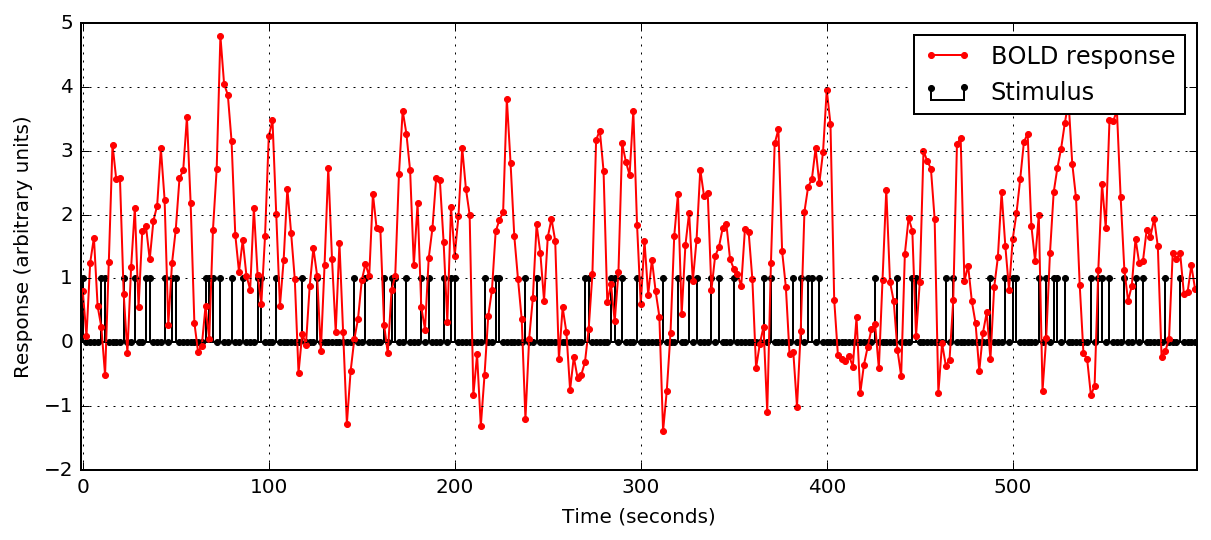

In [23]:
# Load example data
ex_data = np.load('example_data_01.npz')
t = ex_data['t']
stimulus = ex_data['x']
data_sim = ex_data['data']
stim_resp_plot(t, stimulus, data_sim, yl=(-2, 5))

In [24]:
### TEACHER NOTE
# Note that the data has larger variation than previous examples. We *COULD* z-score it... Or just leave it alone.*

Because of the hemodynamic delay, the fMRI response is *NOT* correlated with the stimulus events:

the correlation between the stimulus and the data is -0.02880977393783917


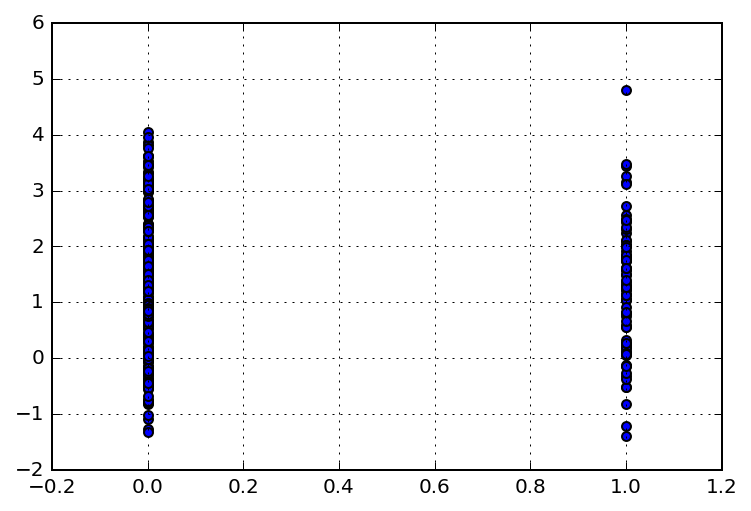

In [25]:
plt.scatter(stimulus, data_sim);
print("the correlation between the stimulus and the data is {}".format(np.corrcoef(stimulus, data_sim)[0,1]))

How would the plot above be different if the data had been correlated?

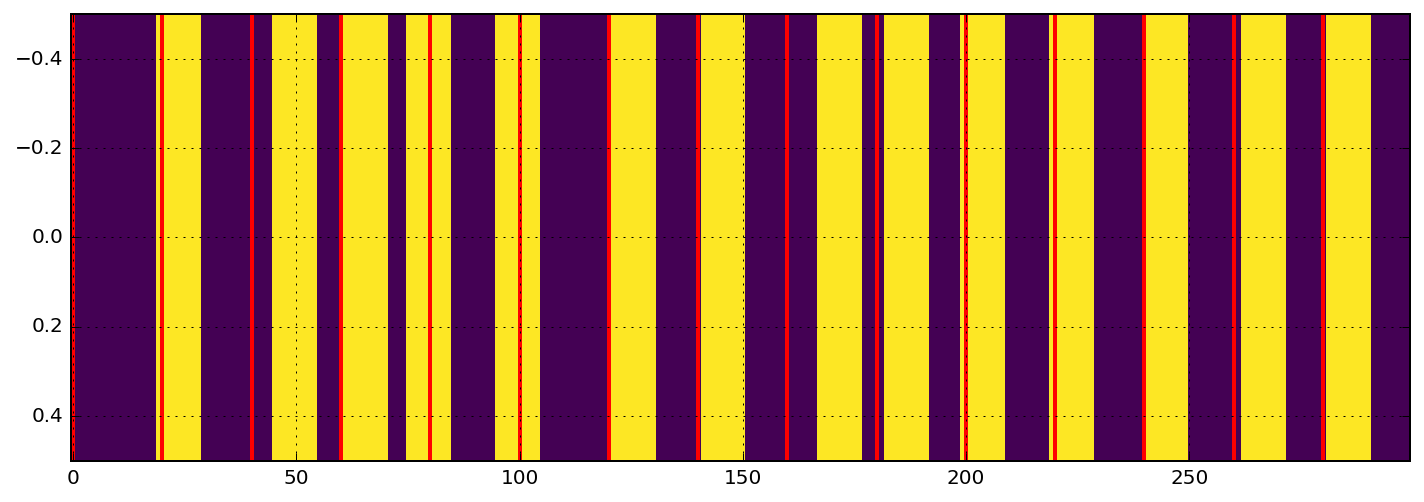

In [26]:
### TEACHER NOTE
# not sure to keep this cell
# Extra: What if we put all our events together in blocks? 
n_tps = 300
n_Bs = 1
X = np.zeros((n_tps,))
# Say, 10 TR events, spaced approximately every 20 TRs
spacing = 20 # TRs
block_length = 10
onsets = np.arange(0, n_tps, spacing)
# add some jitter
jitter_std = 3
jitter = np.round(np.random.randn(len(onsets), ) * jitter_std)
onsets_jittered = onsets + jitter
# Fill blocks
for o in onsets_jittered:
    X[o:o+block_length] = 1
plt.figure(figsize=(12,4))
plt.imshow(X[None,:])
plt.vlines(onsets, -0.5, 0.5, color='r', lw=2);

We know that the presentation of the stimulus should create a hemodynamic response if this voxel is sensitive to that stimulus. We therefore need to convolve the stimulus first with the hemodynamic response. 

But first, look at the time vector:

In [27]:
t[:10]

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.])

The data is sampled with a TR of 2 seconds! Then we need an hrf that is sampled with the same rate. This will be the same curve as before, however only sampled differently.

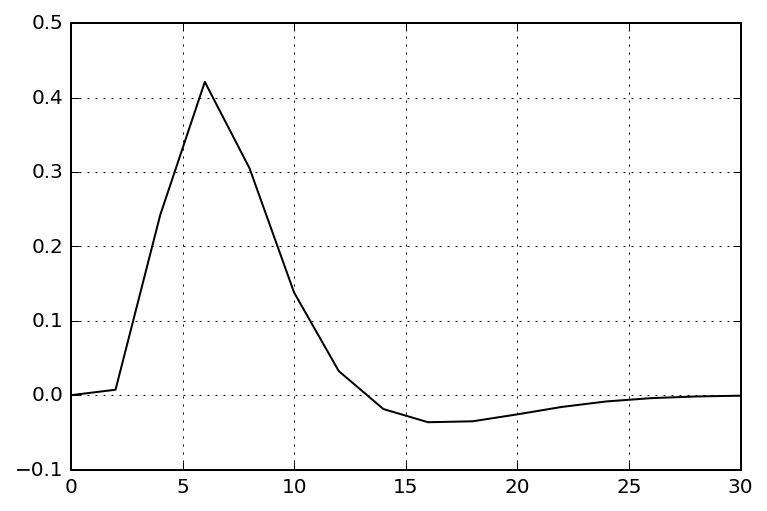

In [28]:
t2, hrf_2 = neurods.fmri.hrf(tr=2)
plt.plot(t2, hrf_2);

Now we can convolve the stimulus:

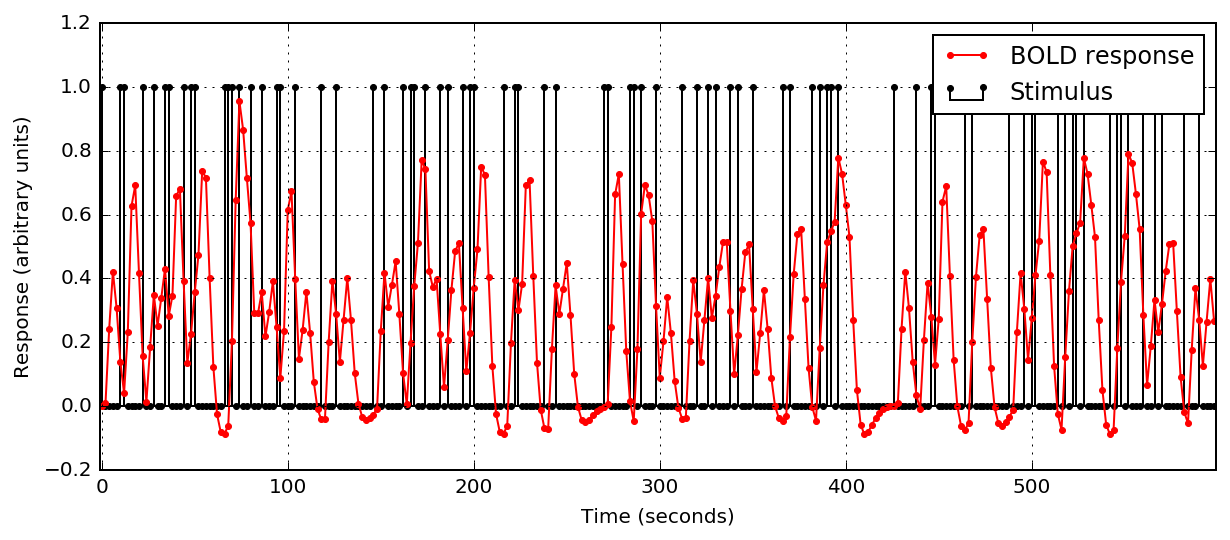

In [29]:
conv_stimulus = np.convolve(stimulus, hrf_2, mode='full')[:n_tps]
stim_resp_plot(t, stimulus, conv_stimulus);

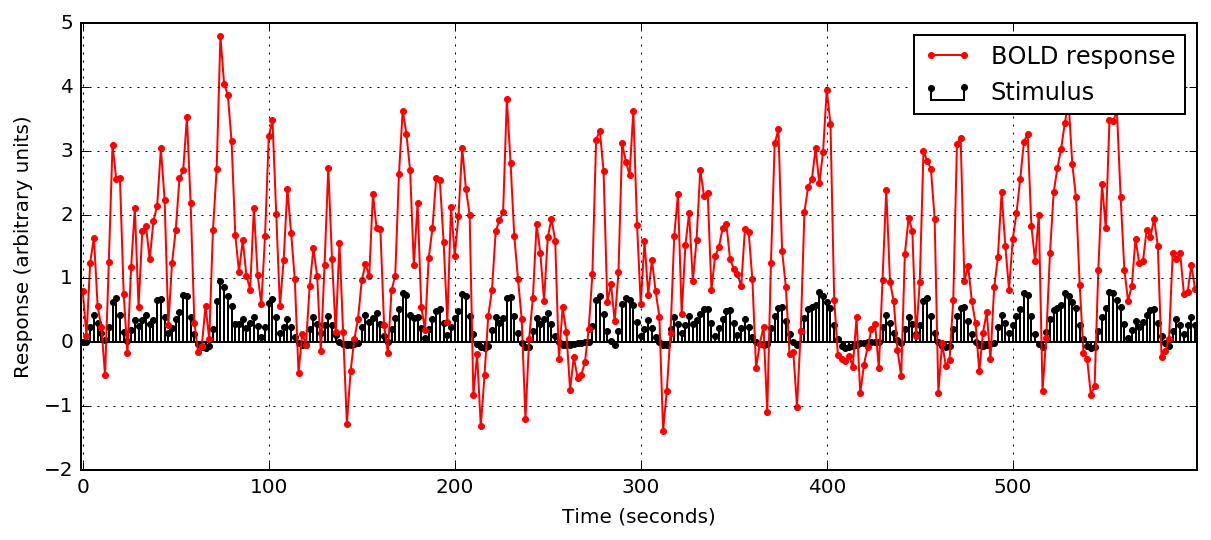

In [30]:
stim_resp_plot(t, conv_stimulus, data_sim, yl=(-2, 5))

the correlation between the stimulus and the data is 0.9062882874583871


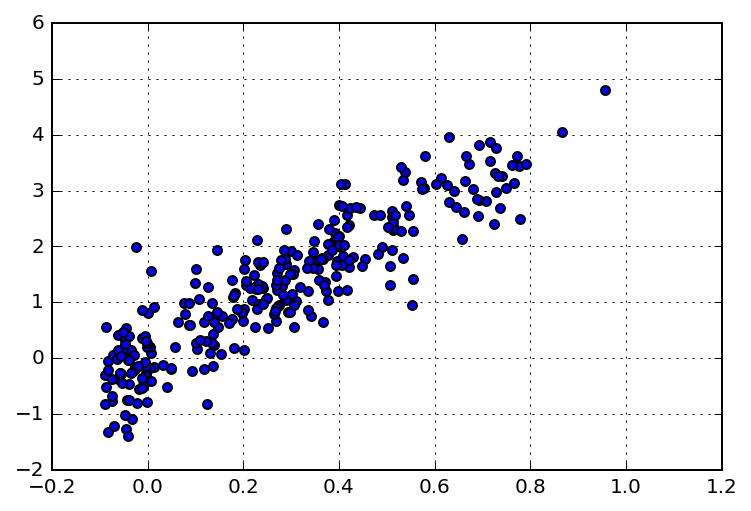

In [31]:
plt.scatter(conv_stimulus, data_sim);
print("the correlation between the stimulus and the data is {}".format(np.corrcoef(conv_stimulus, data_sim)[0,1]))

We can see now we are able to recover a clear relationship between the stimulus and the data. What is the variance of the noise that we can guess from this plot? Had this been real data, this would have been a very clean result. Usually in fMRI we are not so lucky to have effects that are this clear. We will study in future lectures how to can expand this analysis.

Can we estimate from this data the magnitude of the weight $w_v$?

In [32]:
# this function first a straight line through the points above
slope, intercept = np.polyfit(data_sim,conv_stimulus, 1)
print(slope)

0.180840483183


Remember, what is units of this value? FMRI signal doesn't have a unit and can be rescaled and normalized. The weight therefore depends on how the data is normalized and is meaningful only with respect to the variance of the data. 

What happen when we have more than one stimulus?